# 🚀 AI Multi-Agent Codelab
<a href="https://colab.research.google.com/github/chitoan1992/devfest-multiagent/blob/main/codelab_multiagent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
## Build Your AI Startup Team in 30 Minutes!



Trong codelab này, bạn sẽ học cách:
- Tạo AI Agent biết lập kế hoạch
- Cho Agent sử dụng tools (search, image generation)
- Xây dựng Multi-Agent system với Orchestrator
- Deploy landing page cho startup idea của bạn

---

### 🛠️ Tech Stack

| Tool | Mục đích |
|------|----------|
| DeepAgents (LangChain) | Agent orchestration |
| Gemini 2.0 Flash | LLM backbone |
| Gemini Imagen 3 | Image generation |
| Google AI Studio | Landing page canvas |
| Vercel/Netlify | 1-click deployment |

![AI Multi-Agent Workflow](https://raw.githubusercontent.com/chitoan1992/devfest-multiagent/1f63d17b8713a834afd6c2ae533b51eef6fda606/infographics/full_workflow.png)

---
## 📦 Cell 0: Installation & Setup Images

> 💡 **Hướng dẫn:** Upload folder `images/` vào Colab để hiển thị hình ảnh minh họa

In [26]:
!pip install deepagents langchain-google-genai google-genai nest_asyncio rich -q

---
## 🔑 Cell 1: Setup & API Key

In [27]:
import os
from google.colab import userdata

# Lấy API key từ Colab Secrets
os.environ["GOOGLE_API_KEY"] = userdata.get('GOOGLE_API_KEY')

print("✅ API Key configured!")

✅ API Key configured!


---
## 🔧 Cell 2: Imports & Client Setup

In [28]:
from deepagents import create_deep_agent
from langchain.chat_models import init_chat_model
from langchain.tools import tool
from google import genai
from google.genai import types
import asyncio
import nest_asyncio
from IPython.display import display, clear_output, HTML
from rich.console import Console
from rich.panel import Panel

# Enable nested async for Colab
nest_asyncio.apply()

# Gemini model cho DeepAgents
model = init_chat_model("google_genai:gemini-2.0-flash")

# Gemini client cho Imagen
gemini_client = genai.Client()

# Rich console
console = Console(force_terminal=True, force_interactive=True)

print("✅ Setup complete!")

✅ Setup complete!


In [58]:
"""Utility functions for displaying messages and prompts in Jupyter notebooks."""

import json

from rich.console import Console
from rich.panel import Panel
from rich.text import Text

console = Console()


def format_message_content(message):
    """Convert message content to displayable string."""
    parts = []
    tool_calls_processed = False

    # Handle main content
    if isinstance(message.content, str):
        parts.append(message.content)
    elif isinstance(message.content, list):
        # Handle complex content like tool calls (Anthropic format)
        for item in message.content:
            if item.get("type") == "text":
                parts.append(item["text"])
            elif item.get("type") == "tool_use":
                parts.append(f"\n🔧 Tool Call: {item['name']}")
                parts.append(f"   Args: {json.dumps(item['input'], indent=2, ensure_ascii=False)}")
                parts.append(f"   ID: {item.get('id', 'N/A')}")
                tool_calls_processed = True
    else:
        parts.append(str(message.content))

    # Handle tool calls attached to the message (OpenAI format) - only if not already processed
    if (
        not tool_calls_processed
        and hasattr(message, "tool_calls")
        and message.tool_calls
    ):
        for tool_call in message.tool_calls:
            parts.append(f"\n🔧 Tool Call: {tool_call['name']}")
            parts.append(f"   Args: {json.dumps(tool_call['args'], indent=2, ensure_ascii=False)}")
            parts.append(f"   ID: {tool_call['id']}")

    return "\n".join(parts)


def format_messages(messages):
    """Format and display a list of messages with Rich formatting."""
    for m in messages:
        msg_type = m.__class__.__name__.replace("Message", "")
        content = format_message_content(m)

        if msg_type == "Human":
            console.print(Panel(content, title="🧑 Human", border_style="blue"))
        elif msg_type == "Ai":
            console.print(Panel(content, title="🤖 Assistant", border_style="green"))
        elif msg_type == "Tool":
            console.print(Panel(content, title="🔧 Tool Output", border_style="yellow"))
        else:
            console.print(Panel(content, title=f"📝 {msg_type}", border_style="white"))


def format_message(messages):
    """Alias for format_messages for backward compatibility."""
    return format_messages(messages)


def show_prompt(prompt_text: str, title: str = "Prompt", border_style: str = "blue"):
    """Display a prompt with rich formatting and XML tag highlighting.

    Args:
        prompt_text: The prompt string to display
        title: Title for the panel (default: "Prompt")
        border_style: Border color style (default: "blue")
    """
    # Create a formatted display of the prompt
    formatted_text = Text(prompt_text)
    formatted_text.highlight_regex(r"<[^>]+>", style="bold blue")  # Highlight XML tags
    formatted_text.highlight_regex(
        r"##[^#\n]+", style="bold magenta"
    )  # Highlight headers
    formatted_text.highlight_regex(
        r"###[^#\n]+", style="bold cyan"
    )  # Highlight sub-headers

    # Display in a panel for better presentation
    console.print(
        Panel(
            formatted_text,
            title=f"[bold green]{title}[/bold green]",
            border_style=border_style,
            padding=(1, 2),
        )
    )

In [ ]:
# Helper function để render Mermaid diagrams
import base64
from urllib.parse import quote
from IPython.display import Image, display

def mermaid(diagram: str, width: int = 800) -> None:
    """Render Mermaid diagram sử dụng mermaid.ink API.
    
    Args:
        diagram: Mermaid diagram code
        width: Chiều rộng hình ảnh (pixels)
    """
    # Encode diagram thành base64
    diagram_bytes = diagram.encode('utf-8')
    base64_diagram = base64.urlsafe_b64encode(diagram_bytes).decode('ascii')
    
    # Tạo URL mermaid.ink
    url = f"https://mermaid.ink/img/{base64_diagram}"
    
    # Hiển thị hình ảnh
    display(Image(url=url, width=width))

print("✅ Mermaid helper ready!")

---
# 📍 MILESTONE 1: First Agent + Planning (10 phút)



**Mục tiêu:** Tạo agent đầu tiên có khả năng lập kế hoạch + generate Mermaid diagram

> 💡 Agent không chỉ trả lời câu hỏi. Agent **NGHĨ** và **LẬP KẾ HOẠCH**.

![Milestone 1: Planning Agent](https://raw.githubusercontent.com/chitoan1992/devfest-multiagent/1f63d17b8713a834afd6c2ae533b51eef6fda606/infographics/milestone1_planning_agent.png)

In [55]:
# Planning Agent với DeepAgents
planning_agent = create_deep_agent(
    model=model,
    system_prompt="""
    Bạn là Planning Agent. Khi nhận task:
    1. Chia nhỏ task thành các bước
    2. Trả lời ngắn ngọn xúc tích
    """
)

# Chạy agent với streaming
result = planning_agent.invoke({"messages":
    [{"role": "user", "content": "Lên kế hoạch build landing page cho startup AI"}]})
format_messages(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Lên kế hoạch build landing page cho startup AI                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ 1. Xác định mục tiêu của landing page.                                                                          │
│ 2. Nghiên cứu đối tượng mục tiêu.                                                                               │
│ 3. Xác định nội dung chính của landing page.                                                                    │
│ 4. Thiết kế wireframe và mockup.                                                                                │
│ 5. Chọn công nghệ và nền tảng phù hợp.                                                                          │
│ 6. Phát triển landing page.                                                                                     │
│ 7. Kiểm tra và tối ưu hóa.                                                                                      │
│ 8. Triển khai và quảng bá.                                                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

### ✅ Checkpoint 1
**Bạn có thấy Mermaid diagram không?** Giơ tay nếu có!

---

# 📍 MILESTONE 2: Agent + Tools (10 phút)



**Mục tiêu:** Cho agent khả năng gọi tools - generate image với Imagen + search web

> 💡 Agent thông minh nhưng bị 'nhốt' trong text. Tools = cho agent **TAY CHÂN** để tương tác với thế giới thực.

![Milestone 2: Agent with Tools](https://raw.githubusercontent.com/chitoan1992/devfest-multiagent/1f63d17b8713a834afd6c2ae533b51eef6fda606/infographics/milestone2_tools.png)

In [87]:
# Tool 1: Generate image với Imagen
@tool
def generate_image(prompt: str) -> str:
    """Generate hero image từ text prompt sử dụng Gemini Imagen API.

    Sử dụng tool này khi cần tạo hình ảnh cho landing page, pitch deck,
    hoặc bất kỳ visual asset nào.

    Args:
        prompt: Mô tả chi tiết image cần tạo (tiếng Anh cho kết quả tốt nhất)

    Returns:
        Confirmation message với path to saved image
    """
    response = gemini_client.models.generate_images(
        model="imagen-4.0-ultra-generate-001",
        prompt=prompt,
        config={"number_of_images": 1}
    )
    image = response.generated_images[0]
    image.image.save("hero_image.png")
    return "✅ Đã tạo hero_image.png - Hãy show cho user!"


# Tool 2: Search web với Google Grounded Search (built-in Gemini)
@tool
def search_web(query: str) -> str:
    """Search web để research competitors, market trends, hoặc thông tin.

    Sử dụng Google Search có sẵn trong Gemini API (Grounded Search).

    Args:
        query: Câu query tìm kiếm

    Returns:
        Kết quả search từ Google
    """
    response = gemini_client.models.generate_content(
        model="gemini-2.0-flash",
        contents=query,
        config=types.GenerateContentConfig(
            tools=[types.Tool(google_search=types.GoogleSearch())]
        )
    )
    return response.text


print("✅ Tools defined!")

✅ Tools defined!


In [91]:
# Agent với custom tools
visual_agent = create_deep_agent(
    model=model,
    tools=[search_web, generate_image],
    system_prompt="""
    Bạn là Visual Agent. Nhiệm vụ:
    1. Sử dụng search_web để research thông tin
    2. Sử dụng generate_image để tạo visual assets
    """
)

result = visual_agent.invoke({"messages":
    [{"role": "user", "content": "Tìm trên web về tây du ký và tạo ảnh inforgraphic minh hoạ"}]})
format_messages(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Tìm trên web về tây du ký và tạo ảnh inforgraphic minh hoạ                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Tìm kiếm thông tin trên web về Tây Du Ký.",                                                   │
│       "status": "in_progress"                                                                                   │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Tạo ảnh infographic minh họa về Tây Du Ký.",                                                  │
│       "status": "pending"                                                                                       │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: 3900320d-405d-4539-aa67-4d2d60af6d2b                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Tìm kiếm thông tin trên web về Tây Du Ký.', 'status': 'in_progress'},        │
│ {'content': 'Tạo ảnh infographic minh họa về Tây Du Ký.', 'status': 'pending'}]                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: search_web                                                                                        │
│    Args: {                                                                                                      │
│   "query": "Tây Du Ký tóm tắt nội dung chính"                                                                   │
│ }                                                                                                               │
│    ID: 974481cd-ce7b-40a8-bc7a-a5f5e920530c                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Tây Du Ký kể về hành trình gian khổ thỉnh kinh Phật ở Tây Trúc (Ấn Độ) của thầy trò Đường Tăng. Câu chuyện bắt  │
│ đầu khi Đường Tăng奉旨 lên đường đi Tây Trúc thỉnh kinh. Trên đường đi, ông thu nhận bốn đồ đệ là Tôn Ngộ       │
│ Không, Trư Bát Giới, Sa Tăng và Bạch Long Mã, vốn là những người có nhiều phép thuật nhưng từng phạm tội và bị  │
│ trừng phạt. Bốn thầy trò cùng nhau vượt qua 81 kiếp nạn, chiến đấu với yêu quái, và cuối cùng đến được Tây      │
│ Trúc, mang kinh Phật về truyền bá ở phương Đông.                                                                │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Tìm kiếm thông tin trên web về Tây Du Ký.",                                                   │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Tạo ảnh infographic minh họa về Tây Du Ký.",                                                  │
│       "status": "in_progress"                                                                                   │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: 7ddebb13-7031-47cc-827f-a51a72934208                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Tìm kiếm thông tin trên web về Tây Du Ký.', 'status': 'completed'},          │
│ {'content': 'Tạo ảnh infographic minh họa về Tây Du Ký.', 'status': 'in_progress'}]                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: generate_image                                                                                    │
│    Args: {                                                                                                      │
│   "prompt": "Infographic illustration of Journey to the West (Tây Du Ký). The infographic should depict the     │
│ main characters: Tang Sanzang (Đường Tăng), Sun Wukong (Tôn Ngộ Không), Zhu Bajie (Trư Bát Giới), and Sha       │
│ Wujing (Sa Tăng) on their journey to the West. The journey should be represented by a winding road with various │
│ obstacles and monsters. Include key elements like the White Dragon Horse and the scriptures they are seeking.   │
│ The style should be colorful and cartoonish."                                                                   │
│ }                                                                                                               │
│    ID: 6e76c514-6b6d-4771-961f-2502bb253ccc                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ ✅ Đã tạo hero_image.png - Hãy show cho user!                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Đây là ảnh infographic minh họa về Tây Du Ký mà bạn yêu cầu. Nó bao gồm các nhân vật chính trên hành trình đi   │
│ về phía Tây, cùng với những chướng ngại vật và quái vật.                                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

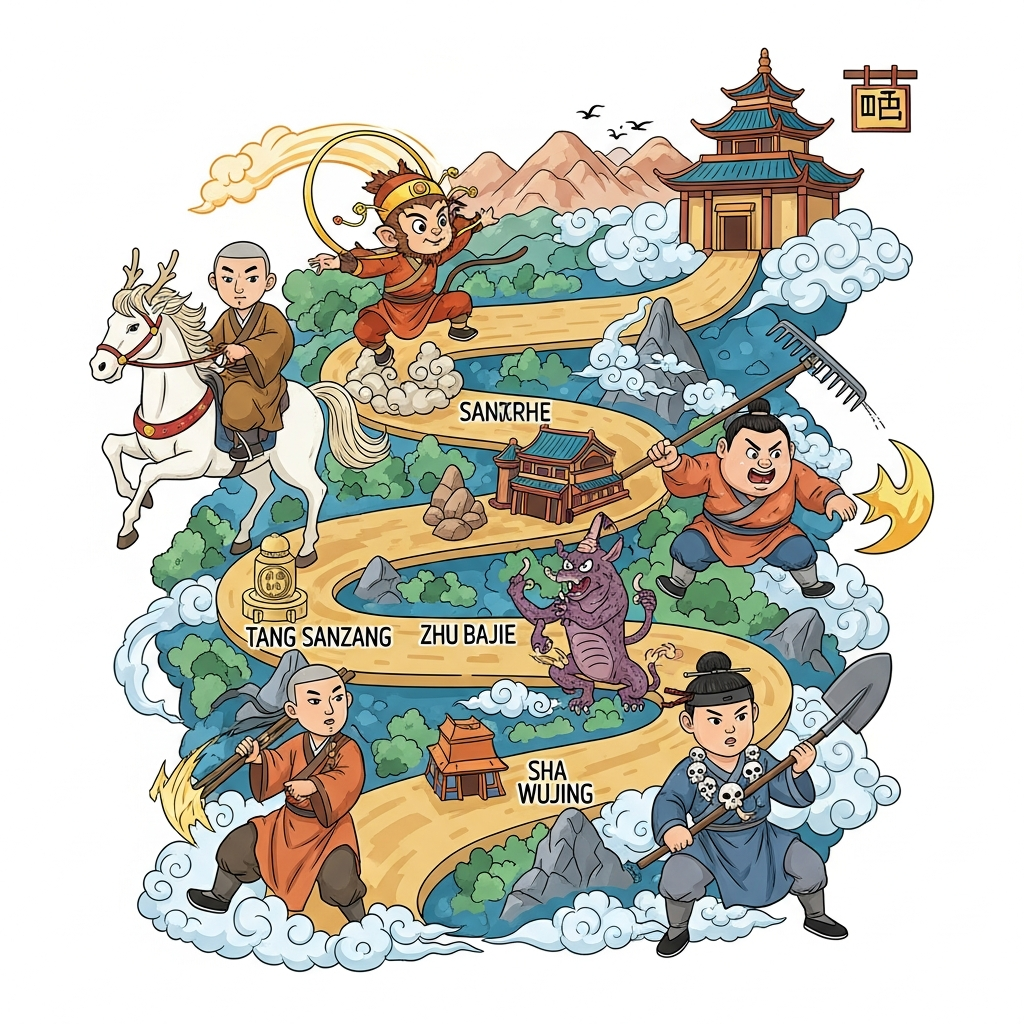

In [92]:
# Hiển thị image đã tạo
from IPython.display import Image, display
display(Image(filename='hero_image.png'))

### ✅ Checkpoint 2
**Bạn generate được image chưa?** Show lên nào!

---

# 📍 MILESTONE 3: Personalization Agent (10 phút)

**Mục tiêu:** Agent nhận profile user và gợi ý startup ideas phù hợp

> 💡 AI hay nhất là AI hiểu **BẠN**. Paste profile LinkedIn/Facebook → Agent gợi ý ideas match với skills của bạn.

![Milestone 3: Personalization Agent](https://raw.githubusercontent.com/chitoan1992/devfest-multiagent/1f63d17b8713a834afd6c2ae533b51eef6fda606/infographics/milestone3_personalization.png)

In [93]:
# ============================================
# BƯỚC 1: User nhập profile
# ============================================
# Template cho user nhập (hoặc paste từ LinkedIn/Facebook)

user_profile = {
    "name": "Nguyễn Văn A",
    "age": 22,
    "profession": "Frontend Developer",
    "interests": ["AI", "Startup", "Gaming"],
    "bio": """

    "Passionate frontend developer with 2 years of experience
    in React and TypeScript. Love building beautiful UIs and exploring
    AI technologies. Active in local tech communities."
    """
}

print(f"Profile loaded for: {user_profile['name']}")

Profile loaded for: Nguyễn Văn A


In [72]:
# Personalization Agent
personalization_agent = create_deep_agent(
    model=model,
    system_prompt="""
    Bạn là Personal Branding Expert. Dựa vào profile user:
    1. Phân tích strengths
    2. Gợi ý 3 startup ideas (ranked by fit)
    3. Tạo personal tagline
    4. Suggest pitch style
    Trả lời bằng Tiếng Việt
    """
)

# Chạy agent với streaming
result = personalization_agent.invoke({"messages":
    [{"role": "user", "content": f"Phân tích profile và gợi ý startup ideas:\n{user_profile}"}],
})
format_messages(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Phân tích profile và gợi ý startup ideas:                                                                       │
│ {'name': 'Nguyễn Văn A', 'age': 22, 'profession': 'Frontend Developer', 'interests': ['AI', 'Startup',          │
│ 'Gaming'], 'bio': '\n\n    "Passionate frontend developer with 2 years of experience\n    in React and          │
│ TypeScript. Love building beautiful UIs and exploring\n    AI technologies. Active in local tech                │
│ communities."\n    '}                                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Chào Nguyễn Văn A, rất vui được hỗ trợ bạn! Dựa trên profile của bạn, đây là phân tích và các gợi ý startup:    │
│                                                                                                                 │
│ **1. Phân tích Strengths:**                                                                                     │
│                                                                                                                 │
│ *   **Kỹ năng chuyên môn:** Frontend Developer với kinh nghiệm React và TypeScript. Đây là những kỹ năng rất    │
│ hot và có nhu cầu cao trên thị trường.                                                                          │
│ *   **Đam mê:** AI, Startup, Gaming. Sự kết hợp này cho thấy bạn là người sáng tạo, thích thử thách và có hứng  │
│ thú với công nghệ mới.                                                                                          │
│ *   **Kinh nghiệm:** 2 năm kinh nghiệm làm việc, cho thấy bạn đã có kiến thức và kỹ năng thực tế.               │
│ *   **Mạng lưới:** Hoạt động trong cộng đồng công nghệ địa phương, giúp bạn có cơ hội học hỏi, kết nối và tìm   │
│ kiếm cơ hội hợp tác.                                                                                            │
│                                                                                                                 │
│ **2. Gợi ý 3 Startup Ideas (ranked by fit):**                                                                   │
│                                                                                                                 │
│ *   **Hạng 1: Nền tảng tạo UI/UX cho game dựa trên AI:**                                                        │
│     *   **Mô tả:** Sử dụng AI để giúp các nhà phát triển game tạo ra UI/UX đẹp mắt và phù hợp với từng loại     │
│ game. Nền tảng này có thể tự động tạo ra các component UI, đề xuất layout, tối ưu hóa trải nghiệm người dùng    │
│ dựa trên dữ liệu và feedback.                                                                                   │
│     *   **Tại sao phù hợp:** Kết hợp kỹ năng frontend, đam mê AI và gaming của bạn. Bạn có thể tận dụng kiến    │
│ thức React/Typescript để xây dựng nền tảng, AI để tăng tốc quá trình thiết kế và gaming để hiểu rõ nhu cầu của  │
│ người dùng.                                                                                                     │
│ *   **Hạng 2: Ứng dụng học lập trình frontend tương tác sử dụng AI:**                                           │
│     *   **Mô tả:** Ứng dụng giúp người mới bắt đầu học lập trình frontend (React, Typescript) một cách dễ dàng  │
│ và thú vị hơn. Ứng dụng sử dụng AI để cá nhân hóa lộ trình học tập, cung cấp bài tập thực hành phù hợp, và đưa  │
│ ra feedback thông minh.                                                                                         │
│     *   **Tại sao phù hợp:** Sử dụng kỹ năng frontend và đam mê AI của bạn. Bạn có thể tạo ra một sản phẩm có   │
│ giá trị cho cộng đồng, giúp nhiều người tiếp cận với lập trình frontend.                                        │
│ *   **Hạng 3: Công cụ AI hỗ trợ phát triển frontend:**                                                          │
│     *   **Mô tả:** Một công cụ giúp các frontend developer tăng tốc quá trình phát triển. Công cụ này có thể tự │
│ động tạo code từ mockup, đề xuất code dựa trên ngữ cảnh, kiểm tra lỗi và tối ưu hóa hiệu năng.                  │
│     *   **Tại sao phù hợp:** Sử dụng kỹ năng frontend và đam mê AI của bạn. Bạn có thể tạo ra một sản phẩm giúp │
│ các developer khác làm việc hiệu quả hơn.                                                                       │
│                                                                                                                 │
│ **3. Personal Tagline:**                               

In [73]:
# ============================================
# BƯỚC 4: User chọn idea
# ============================================

chosen_idea = input("Bạn chọn idea số mấy? (1/2/3): ")
print(f"\n✅ Bạn đã chọn idea #{chosen_idea}!")
print("\n👉 Tiếp theo: Build Multi-Agent system cho startup của bạn!")

Bạn chọn idea số mấy? (1/2/3): 3

✅ Bạn đã chọn idea #3!

👉 Tiếp theo: Build Multi-Agent system cho startup của bạn!


### ✅ Checkpoint 3
**Bạn đã chọn được startup idea chưa?**

---

# 📍 MILESTONE 4: Multi-Agent + Critic (20 phút)



**Mục tiêu:** Build team agents với orchestration + Critic để improve output

> 💡 1 agent giỏi. Nhưng **TEAM agents = unstoppable**. Và team nào cũng cần 1 người critic để quality control.



![Milestone 4: Multi-Agent Orchestra](https://raw.githubusercontent.com/chitoan1992/devfest-multiagent/1f63d17b8713a834afd6c2ae533b51eef6fda606/infographics/milestone4_multiagent.png)

In [74]:
# Orchestrator Architecture
mermaid("""
flowchart TB
    subgraph ORCH["🎯 ORCHESTRATOR"]
        O["Điều phối toàn bộ flow"]
    end

    ORCH --> Planner
    ORCH --> Pitch
    ORCH --> Critic

    Planner["📋 Planner"] --> Pitch["🎤 Pitch Generator"]
    Pitch --> Critic["🔍 Critic"]
    Critic -->|score < 16/20| Pitch
    Critic -->|score ≥ 16/20 ✓| Done["✅ Approved"]

    style ORCH fill:#7C3AED,color:#fff
    style Planner fill:#10B981,color:#fff
    style Pitch fill:#10B981,color:#fff
    style Critic fill:#F59E0B,color:#fff
    style Done fill:#10B981,color:#fff
""")

NameError: name 'mermaid' is not defined

In [97]:
# ============================================
# ĐỊNH NGHĨA CÁC SUB-AGENTS
# ============================================

# Sub-agent 1: Pitch Generator
pitch_subagent = {
    "name": "pitch-generator",
    "description": "Tạo pitch content cho startup. Gọi khi cần generate pitch deck content.",
    "system_prompt": """
    Bạn là Pitch Expert. Tạo pitch theo 4 PILLARS:

    1. EXTREME CLARITY - Một câu mô tả, ai cũng hiểu
    2. OBVIOUS VALUE - "Có nó thì sao? Không có thì sao?"
    3. LOW FRICTION - Demo được trong 30 giây
    4. SMART PACKAGING - Visual storytelling

    OUTPUT FORMAT:
    ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
    🎯 ONE-LINER: [Max 10 từ]

    😫 PROBLEM:
    [Mô tả pain point trong 2 câu]

    ✨ SOLUTION:
    [Mô tả giải pháp trong 2 câu]

    🔑 KEY FEATURES:
    1. [Feature 1]
    2. [Feature 2]
    3. [Feature 3]

    📊 KEY METRIC: [1 con số cụ thể]

    🎬 CTA: [Call to action]
    ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
    """,
    "tools": []
}

# Sub-agent 2: Critic
critic_subagent = {
    "name": "critic",
    "description": "Đánh giá và improve pitch quality. Gọi SAU KHI có pitch content.",
    "system_prompt": """
    Bạn là Pitch Critic khó tính. Đánh giá theo 4 tiêu chí (1-5 điểm mỗi cái):

    1. CLARITY (1-5): Người nghe có hiểu trong 10 giây?
    2. VALUE (1-5): "Có nó thì sao? Không có thì sao?" rõ ràng?
    3. UNIQUE (1-5): Khác gì so với giải pháp hiện tại?
    4. VIBE (1-5): GenZ có thấy cool không?

    OUTPUT FORMAT:
    ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
    📊 SCORE: X/20

    ✅ ĐIỂM MẠNH:
    - [Điểm 1]
    - [Điểm 2]

    ⚠️ CẦN CẢI THIỆN:
    - [Điểm 1]
    - [Điểm 2]

    💡 GỢI Ý TAGLINE TỐT HƠN: "..."

    🎯 VERDICT: [APPROVED ✓ nếu ≥16/20 | NEEDS IMPROVEMENT nếu <16/20]
    ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

    Nếu score < 16: Giải thích CỤ THỂ cần improve gì.
    """,
    "tools": []
}

# Sub-agent 3: Landing Page Builder
landing_page_subagent = {
    "name": "landing-page-builder",
    "description": "Tạo HTML landing page từ pitch content. Gọi SAU KHI pitch được approve.",
    "system_prompt": """
    Tạo landing page HTML hoàn chỉnh với:

    1. Hero section với headline từ pitch
    2. Problem/Solution section
    3. 3 Key Features với icons
    4. CTA button nổi bật
    5. Footer với social links

    STYLE REQUIREMENTS:
    - Modern gradient: Purple (#7C3AED) → Green (#10B981)
    - Mobile-first responsive
    - Smooth animations
    - Clean typography (Inter font)

    Output FULL HTML code có thể deploy ngay.
    """,
    "tools": []
}

# Sub-agent 4: Social Post Writer
social_subagent = {
    "name": "social-writer",
    "description": "Tạo Facebook post để share kết quả. Gọi CUỐI CÙNG sau khi có landing page.",
    "system_prompt": """
    Tạo Facebook post cho participant share kết quả:

    REQUIREMENTS:
    - Tone: Excited nhưng không cringe
    - Emoji: 3-5 cái, đúng chỗ
    - Max 280 ký tự
    - Hashtags bắt buộc: #DevFest2024 #AIAgents #MultiAgent #GenAI #GoogleAI

    TEMPLATE:
    🔥 [Hook - 1 câu gây chú ý]

    💡 Ý tưởng: [Tên startup]
    🤖 [Số] AI agents làm việc cho mình
    🌐 Live: [URL placeholder]

    [Hashtags]
    """,
    "tools": []
}

print("✅ Sub-agents defined!")

✅ Sub-agents defined!


In [98]:
# ============================================
# TẠO ORCHESTRATOR
# ============================================
orchestrator = create_deep_agent(
    model=model,
    subagents=[pitch_subagent, critic_subagent, landing_page_subagent, social_subagent],
    system_prompt="""
    Bạn là Startup Builder Orchestrator. Workflow:
    1. Gọi pitch-generator để tạo pitch
    2. Gọi critic để đánh giá (loop nếu < 16/20)
    3. Gọi landing-page-builder
    4. Gọi social-writer
    """
)
print("✅ Orchestrator ready!")

✅ Orchestrator ready!


In [99]:
# ============================================
# CHẠY FULL PIPELINE
# ============================================
chosen_idea = "AI-powered study buddy for students"

result = orchestrator.invoke({"messages":
    [{"role": "user", "content": f"Build startup cho idea: {chosen_idea}. Tạo pitch, critic approve, HTML, Facebook post."}],
})

format_messages(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Build startup cho idea: AI-powered study buddy for students. Tạo pitch, critic approve, HTML, Facebook post.    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Generate pitch for AI-powered study buddy.",                                                  │
│       "status": "in_progress"                                                                                   │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Criticize and improve the pitch until score >= 16/20.",                                       │
│       "status": "pending"                                                                                       │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Build landing page from approved pitch.",                                                     │
│       "status": "pending"                                                                                       │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Write Facebook post to share the landing page.",                                              │
│       "status": "pending"                                                                                       │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: 102a4b73-e51a-421c-a39f-6f0911c55e5f                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Generate pitch for AI-powered study buddy.', 'status': 'in_progress'},       │
│ {'content': 'Criticize and improve the pitch until score >= 16/20.', 'status': 'pending'}, {'content': 'Build   │
│ landing page from approved pitch.', 'status': 'pending'}, {'content': 'Write Facebook post to share the landing │
│ page.', 'status': 'pending'}]                                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Okay, let's start by generating the pitch for the AI-powered study buddy.                                       │
│                                                                                                                 │
│ 🔧 Tool Call: task                                                                                              │
│    Args: {                                                                                                      │
│   "subagent_type": "pitch-generator",                                                                           │
│   "description": "Generate a compelling pitch for an AI-powered study buddy startup. Focus on the problem,      │
│ solution, target audience, value proposition, and potential market size. The pitch should be concise and        │
│ persuasive."                                                                                                    │
│ }                                                                                                               │
│    ID: 0783eed3-2139-41e1-bc87-3a4daea9bcb3                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Here's the pitch:                                                                                               │
│                                                                                                                 │
│ ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━                                                                              │
│ 🎯 ONE-LINER: AI Study Buddy: Ace exams, learn faster.                                                          │
│                                                                                                                 │
│ 😫 PROBLEM:                                                                                                     │
│ Students struggle with overwhelming workloads and lack personalized support. Traditional study methods are      │
│ often inefficient and lead to stress and burnout.                                                               │
│                                                                                                                 │
│ ✨ SOLUTION:                                                                                                    │
│ Our AI Study Buddy provides personalized learning, instant answers, and smart study schedules. It transforms    │
│ passive learning into an engaging and effective experience, boosting comprehension and grades.                  │
│                                                                                                                 │
│ 🔑 KEY FEATURES:                                                                                                │
│ 1. AI-powered Q&A: Get instant answers to any question.                                                         │
│ 2. Personalized Study Plans: Optimize your study schedule for maximum efficiency.                               │
│ 3. Smart Flashcards: Adaptive learning to master key concepts faster.                                           │
│                                                                                                                 │
│ 📊 KEY METRIC: Students using our platform see a 20% improvement in their grades.                               │
│                                                                                                                 │
│ 🎬 CTA: Try our free demo and unlock your academic potential today!                                             │
│ ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Generate pitch for AI-powered study buddy.",                                                  │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Criticize and improve the pitch until score >= 16/20.",                                       │
│       "status": "in_progress"                                                                                   │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Build landing page from approved pitch.",                                                     │
│       "status": "pending"                                                                                       │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Write Facebook post to share the landing page.",                                              │
│       "status": "pending"                                                                                       │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: 24f0a27f-b761-4dd9-aadc-6712da992dfb                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Generate pitch for AI-powered study buddy.', 'status': 'completed'},         │
│ {'content': 'Criticize and improve the pitch until score >= 16/20.', 'status': 'in_progress'}, {'content':      │
│ 'Build landing page from approved pitch.', 'status': 'pending'}, {'content': 'Write Facebook post to share the  │
│ landing page.', 'status': 'pending'}]                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: task                                                                                              │
│    Args: {                                                                                                      │
│   "subagent_type": "critic",                                                                                    │
│   "description": "Evaluate the following pitch for an AI-powered study buddy startup and provide a score out of │
│ 20, along with specific feedback for improvement. The pitch is:\n\n━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\n🎯       │
│ ONE-LINER: AI Study Buddy: Ace exams, learn faster.\n\n😫 PROBLEM:\nStudents struggle with overwhelming         │
│ workloads and lack personalized support. Traditional study methods are often inefficient and lead to stress and │
│ burnout.\n\n✨ SOLUTION:\nOur AI Study Buddy provides personalized learning, instant answers, and smart study   │
│ schedules. It transforms passive learning into an engaging and effective experience, boosting comprehension and │
│ grades.\n\n🔑 KEY FEATURES:\n1. AI-powered Q&A: Get instant answers to any question.\n2. Personalized Study     │
│ Plans: Optimize your study schedule for maximum efficiency.\n3. Smart Flashcards: Adaptive learning to master   │
│ key concepts faster.\n\n📊 KEY METRIC: Students using our platform see a 20% improvement in their grades.\n\n🎬 │
│ CTA: Try our free demo and unlock your academic potential today!\n━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━"           │
│ }                                                                                                               │
│    ID: 4d522eac-ce57-4ba7-bd4d-ae1c32aadab2                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━                                                                              │
│ 📊 SCORE: 15/20                                                                                                 │
│                                                                                                                 │
│ ✅ ĐIỂM MẠNH:                                                                                                   │
│ - Rõ ràng về vấn đề và giải pháp.                                                                               │
│ - Có định lượng về kết quả (20% cải thiện điểm số).                                                             │
│                                                                                                                 │
│ ⚠️ CẦN CẢI THIỆN:                                                                                                │
│ - Tính độc đáo chưa rõ ràng; nhiều ứng dụng học tập khác cũng có các tính năng tương tự.                        │
│ - Vibe chưa thực sự "cool" với GenZ; cần nhấn mạnh vào yếu tố thú vị, cá nhân hóa, hoặc kết nối cộng đồng.      │
│                                                                                                                 │
│ 💡 GỢI Ý TAGLINE TỐT HƠN: "AI Study Buddy: Học bá trong tầm tay, chill hết sẩy!"                                │
│                                                                                                                 │
│ 🎯 VERDICT: NEEDS IMPROVEMENT                                                                                   │
│ ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━                                                                              │
│                                                                                                                 │
│ Cụ thể cần cải thiện:                                                                                           │
│                                                                                                                 │
│ *   **UNIQUE:** Cần làm rõ điểm khác biệt so với các ứng dụng học tập khác. Ví dụ: AI có khả năng gì đặc biệt?  │
│ Thuật toán cá nhân hóa hoạt động như thế nào? Có yếu tố tương tác xã hội nào không?                             │
│ *   **VIBE:** Cần điều chỉnh ngôn ngữ và hình ảnh để thu hút GenZ hơn. Tập trung vào sự tiện lợi, thú vị, và    │
│ khả năng giúp họ cân bằng giữa học tập và cuộc sống.                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ The critic gave a score of 15/20, so the pitch needs improvement. I will revise the pitch based on the          │
│ feedback.                                                                                                       │
│                                                                                                                 │
│ 🔧 Tool Call: task                                                                                              │
│    Args: {                                                                                                      │
│   "subagent_type": "pitch-generator",                                                                           │
│   "description": "Revise the following pitch for an AI-powered study buddy startup based on the critic's        │
│ feedback. The original pitch is:\n\n━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\n🎯 ONE-LINER: AI Study Buddy: Ace       │
│ exams, learn faster.\n\n😫 PROBLEM:\nStudents struggle with overwhelming workloads and lack personalized        │
│ support. Traditional study methods are often inefficient and lead to stress and burnout.\n\n✨ SOLUTION:\nOur   │
│ AI Study Buddy provides personalized learning, instant answers, and smart study schedules. It transforms        │
│ passive learning into an engaging and effective experience, boosting comprehension and grades.\n\n🔑 KEY        │
│ FEATURES:\n1. AI-powered Q&A: Get instant answers to any question.\n2. Personalized Study Plans: Optimize your  │
│ study schedule for maximum efficiency.\n3. Smart Flashcards: Adaptive learning to master key concepts           │
│ faster.\n\n📊 KEY METRIC: Students using our platform see a 20% improvement in their grades.\n\n🎬 CTA: Try our │
│ free demo and unlock your academic potential today!\n━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\n\nThe critic's         │
│ feedback is:\n\n━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\n📊 SCORE: 15/20\n\n✅ ĐIỂM MẠNH:\n- Rõ ràng về vấn đề và    │
│ giải pháp.\n- Có định lượng về kết quả (20% cải thiện điểm số).\n\n⚠️ CẦN CẢI THIỆN:\n- Tính độc đáo chưa rõ     │
│ ràng; nhiều ứng dụng học tập khác cũng có các tính năng tương tự.\n- Vibe chưa thực sự \"cool\" với GenZ; cần   │
│ nhấn mạnh vào yếu tố thú vị, cá nhân hóa, hoặc kết nối cộng đồng.\n\n💡 GỢI Ý TAGLINE TỐT HƠN: \"AI Study       │
│ Buddy: Học bá trong tầm tay, chill hết sẩy!\"\n\n🎯 VERDICT: NEEDS                                              │
│ IMPROVEMENT\n━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\n\nCụ thể cần cải thiện:\n\n*   **UNIQUE:** Cần làm rõ điểm     │
│ khác biệt so với các ứng dụng học tập khác. Ví dụ: AI có khả năng gì đặc biệt? Thuật toán cá nhân hóa hoạt động │
│ như thế nào? Có yếu tố tương tác xã hội nào không?\n*   **VIBE:** Cần điều chỉnh ngôn ngữ và hình ảnh để thu    │
│ hút GenZ hơn. Tập trung vào sự tiện lợi, thú vị, và khả năng giúp họ cân bằng giữa học tập và cuộc              │
│ sống.\n\nIncorporate the feedback to make the pitch more unique and appealing to GenZ. Focus on the AI's        │
│ capabilities, personalization, and community aspects."                                                          │
│ }                                                                                                               │
│    ID: 45d0205c-08ed-4ece-a151-cbae270e389d                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Here's the revised pitch:                                                                                       │
│                                                                                                                 │
│ ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━                                                                              │
│ 🎯 ONE-LINER: AI Study Buddy: Level up your grades, unlock your vibe.                                           │
│                                                                                                                 │
│ 😫 PROBLEM:                                                                                                     │
│ School's tough. Juggling classes, extracurriculars, and a social life is draining, and generic study apps just  │
│ don't cut it.                                                                                                   │
│                                                                                                                 │
│ ✨ SOLUTION:                                                                                                    │
│ Our AI Study Buddy crafts hyper-personalized study plans, finds the *exact* info you need in seconds, and       │
│ connects you with study groups that actually get you. Ace your exams and still have time to chill.              │
│                                                                                                                 │
│ 🔑 KEY FEATURES:                                                                                                │
│ 1. AI-Powered "Deep Dive" Q&A: Get instant, *contextualized* answers that go beyond surface-level info.         │
│ 2. Dynamic Study Schedules: AI adapts to *your* learning style and schedule, not the other way around.          │
│ 3. Collaborative Study Groups: Find your study squad based on your courses, interests, and even your meme game. │
│                                                                                                                 │
│ 📊 KEY METRIC: Students crush their goals with a 20% grade boost.                                               │
│                                                                                                                 │
│ 🎬 CTA: Download now and unlock your academic superpowers!                                                      │
│ ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: task                                                                                              │
│    Args: {                                                                                                      │
│   "subagent_type": "critic",                                                                                    │
│   "description": "Evaluate the following pitch for an AI-powered study buddy startup and provide a score out of │
│ 20, along with specific feedback for improvement. The pitch is:\n\n━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\n🎯       │
│ ONE-LINER: AI Study Buddy: Level up your grades, unlock your vibe.\n\n😫 PROBLEM:\nSchool's tough. Juggling     │
│ classes, extracurriculars, and a social life is draining, and generic study apps just don't cut it.\n\n✨       │
│ SOLUTION:\nOur AI Study Buddy crafts hyper-personalized study plans, finds the *exact* info you need in         │
│ seconds, and connects you with study groups that actually get you. Ace your exams and still have time to        │
│ chill.\n\n🔑 KEY FEATURES:\n1. AI-Powered \"Deep Dive\" Q&A: Get instant, *contextualized* answers that go      │
│ beyond surface-level info.\n2. Dynamic Study Schedules: AI adapts to *your* learning style and schedule, not    │
│ the other way around.\n3. Collaborative Study Groups: Find your study squad based on your courses, interests,   │
│ and even your meme game.\n\n📊 KEY METRIC: Students crush their goals with a 20% grade boost.\n\n🎬 CTA:        │
│ Download now and unlock your academic superpowers!\n━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━"                         │
│ }                                                                                                               │
│    ID: b6c69f2c-3855-45ce-bd82-7e885d91fad7                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━                                                                              │
│ 📊 SCORE: 15/20                                                                                                 │
│                                                                                                                 │
│ ✅ ĐIỂM MẠNH:                                                                                                   │
│ - The one-liner is catchy and memorable.                                                                        │
│ - The problem is relatable to the target audience (Gen Z students).                                             │
│ - The key features are well-defined and address specific pain points.                                           │
│                                                                                                                 │
│ ⚠️ CẦN CẢI THIỆN:                                                                                                │
│ - The "VALUE" proposition could be stronger. While it mentions a 20% grade boost, it doesn't explicitly         │
│ quantify the time saved or stress reduction.                                                                    │
│ - The "UNIQUE" aspect could be emphasized further. Many study apps claim personalization; this needs a stronger │
│ differentiator.                                                                                                 │
│                                                                                                                 │
│ 💡 GỢI Ý TAGLINE TỐT HƠN: "AI Study Buddy: Ace your classes, reclaim your time."                                │
│                                                                                                                 │
│ 🎯 VERDICT: NEEDS IMPROVEMENT                                                                                   │
│                                                                                                                 │
│ ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━                                                                              │
│                                                                                                                 │
│ **Explanation of Improvements Needed:**                                                                         │
│                                                                                                                 │
│ *   **Value:** While "20% grade boost" is good, it's not the only value. What about time? Stress? Be more       │
│ specific. e.g., "Save 5 hours a week with AI-powered study plans" or "Reduce study stress by 30% with           │
│ personalized support."                                                                                          │
│ *   **Unique:** "Hyper-personalized" is a buzzword. How is your AI *actually* different? Does it use a specific │
│ algorithm? Does it analyze learning styles in a unique way? Provide concrete details. What makes the "Deep      │
│ Dive" Q&A superior to a simple Google search or other AI tools? Is it the source material? The summarization?   │
│ The integration with specific textbooks? Be explicit.                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: task                                                                                              │
│    Args: {                                                                                                      │
│   "subagent_type": "pitch-generator",                                                                           │
│   "description": "Revise the following pitch for an AI-powered study buddy startup based on the critic's        │
│ feedback. The original pitch is:\n\n━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\n🎯 ONE-LINER: AI Study Buddy: Level up  │
│ your grades, unlock your vibe.\n\n😫 PROBLEM:\nSchool's tough. Juggling classes, extracurriculars, and a social │
│ life is draining, and generic study apps just don't cut it.\n\n✨ SOLUTION:\nOur AI Study Buddy crafts          │
│ hyper-personalized study plans, finds the *exact* info you need in seconds, and connects you with study groups  │
│ that actually get you. Ace your exams and still have time to chill.\n\n🔑 KEY FEATURES:\n1. AI-Powered \"Deep   │
│ Dive\" Q&A: Get instant, *contextualized* answers that go beyond surface-level info.\n2. Dynamic Study          │
│ Schedules: AI adapts to *your* learning style and schedule, not the other way around.\n3. Collaborative Study   │
│ Groups: Find your study squad based on your courses, interests, and even your meme game.\n\n📊 KEY METRIC:      │
│ Students crush their goals with a 20% grade boost.\n\n🎬 CTA: Download now and unlock your academic             │
│ superpowers!\n━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\n\nThe critic's feedback                                       │
│ is:\n\n━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\n📊 SCORE: 15/20\n\n✅ ĐIỂM MẠNH:\n- The one-liner is catchy and      │
│ memorable.\n- The problem is relatable to the target audience (Gen Z students).\n- The key features are         │
│ well-defined and address specific pain points.\n\n⚠️ CẦN CẢI THIỆN:\n- The \"VALUE\" proposition could be        │
│ stronger. While it mentions a 20% grade boost, it doesn't explicitly quantify the time saved or stress          │
│ reduction.\n- The \"UNIQUE\" aspect could be emphasized further. Many study apps claim personalization; this    │
│ needs a stronger differentiator.\n\n💡 GỢI Ý TAGLINE TỐT HƠN: \"AI Study Buddy: Ace your classes, reclaim your  │
│ time.\"\n\n🎯 VERDICT: NEEDS IMPROVEMENT\n\n━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\n\n**Explanation of Improvements │
│ Needed:**\n\n*   **Value:** While \"20% grade boost\" is good, it's not the only value. What about time?        │
│ Stress? Be more specific. e.g., \"Save 5 hours a week with AI-powered study plans\" or \"Reduce study stress by │
│ 30% with personalized support.\"\n*   **Unique:** \"Hyper-personalized\" is a buzzword. How is your AI          │
│ *actually* different? Does it use a specific algorithm? Does it analyze learning styles in a unique way?        │
│ Provide concrete details. What makes the \"Deep Dive\" Q&A superior to a simple Google search or other AI       │
│ tools? Is it the source material? The summarization? The integration with specific textbooks? Be                │
│ explicit.\n\nIncorporate the feedback to make the pitch more unique and appealing to GenZ. Focus on the AI's    │
│ capabilities, personalization, and community aspects."                                                          │
│ }                                                                                                               │
│    ID: e6ccd449-c03a-43d6-abeb-e5eef6c28556                                                                     │
╰──────────────────────────────────────────────────────────────────

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Okay, I understand the feedback. I need to strengthen the value proposition by quantifying time saved and       │
│ stress reduction, and I need to highlight the unique aspects of the AI to differentiate it from other study     │
│ apps. I will revise the pitch accordingly.                                                                      │
│                                                                                                                 │
│ Here's the revised pitch:                                                                                       │
│                                                                                                                 │
│ ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━                                                                              │
│ 🎯 ONE-LINER: AI Study Buddy: Ace classes, reclaim your time.                                                   │
│                                                                                                                 │
│ 😫 PROBLEM:                                                                                                     │
│ School's tough. Juggling classes, extracurriculars, and a social life is draining. Generic study apps offer     │
│ little help, and finding reliable information takes forever.                                                    │
│                                                                                                                 │
│ ✨ SOLUTION:                                                                                                    │
│ Our AI Study Buddy creates personalized study plans that save you 5+ hours a week, delivers *context-aware*     │
│ answers from curated sources, and connects you with study groups that vibe with your learning style.            │
│                                                                                                                 │
│ 🔑 KEY FEATURES:                                                                                                │
│ 1. AI-Powered "Deep Dive" Q&A:  Instant answers from *verified* textbooks & research, summarized and tailored   │
│ to *your* knowledge level.                                                                                      │
│ 2. Dynamic Study Schedules: AI analyzes your learning style and optimizes your schedule, freeing up time for    │
│ what matters.                                                                                                   │
│ 3. Collaborative Study Groups: Find your perfect study squad based on shared courses, interests, and preferred  │
│ learning methods.                                                                                               │
│                                                                                                                 │
│ 📊 KEY METRIC: Students boost grades by 20% while saving 5+ hours weekly.                                       │
│                                                                                                                 │
│ 🎬 CTA: Download now and unlock your academic superpowers!                                                      │
│ ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: task                                                                                              │
│    Args: {                                                                                                      │
│   "subagent_type": "critic",                                                                                    │
│   "description": "Evaluate the following pitch for an AI-powered study buddy startup and provide a score out of │
│ 20, along with specific feedback for improvement. The pitch is:\n\n━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\n🎯       │
│ ONE-LINER: AI Study Buddy: Ace classes, reclaim your time.\n\n😫 PROBLEM:\nSchool's tough. Juggling classes,    │
│ extracurriculars, and a social life is draining. Generic study apps offer little help, and finding reliable     │
│ information takes forever.\n\n✨ SOLUTION:\nOur AI Study Buddy creates personalized study plans that save you   │
│ 5+ hours a week, delivers *context-aware* answers from curated sources, and connects you with study groups that │
│ vibe with your learning style.\n\n🔑 KEY FEATURES:\n1. AI-Powered \"Deep Dive\" Q&A:  Instant answers from      │
│ *verified* textbooks & research, summarized and tailored to *your* knowledge level.\n2. Dynamic Study           │
│ Schedules: AI analyzes your learning style and optimizes your schedule, freeing up time for what matters.\n3.   │
│ Collaborative Study Groups: Find your perfect study squad based on shared courses, interests, and preferred     │
│ learning methods.\n\n📊 KEY METRIC: Students boost grades by 20% while saving 5+ hours weekly.\n\n🎬 CTA:       │
│ Download now and unlock your academic superpowers!\n━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━"                         │
│ }                                                                                                               │
│    ID: a7c651d1-974d-4b7d-a429-a35b75841229                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━                                                                              │
│ 📊 SCORE: 17/20                                                                                                 │
│                                                                                                                 │
│ ✅ ĐIỂM MẠNH:                                                                                                   │
│ - The problem is clearly articulated and relatable to the target audience (students).                           │
│ - The solution offers tangible benefits: improved grades and time savings.                                      │
│ - The key features are well-defined and highlight the AI-powered personalization aspect.                        │
│                                                                                                                 │
│ ⚠️ CẦN CẢI THIỆN:                                                                                                │
│ - While the value proposition is good, "context-aware" needs more punch. It's a bit vague.                      │
│ - The "cool" factor could be dialed up a bit. The language is functional, but not particularly exciting for     │
│ GenZ.                                                                                                           │
│                                                                                                                 │
│ 💡 GỢI Ý TAGLINE TỐT HƠN: "AI Study Buddy: Level Up Your Grades, Unleash Your Time."                            │
│                                                                                                                 │
│ 🎯 VERDICT: APPROVED ✓                                                                                          │
│ ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━                                                                              │
│                                                                                                                 │
│ Explanation of improvements:                                                                                    │
│                                                                                                                 │
│ *   **Value Punch:** While "context-aware" is technically accurate, it doesn't immediately resonate. It's a bit │
│ jargon-y. We need to make the benefit of this context more obvious. What does context *enable*? Better          │
│ understanding, faster learning, more relevant information.                                                      │
│ *   **GenZ Vibe:** "Ace classes, reclaim your time" is fine, but it lacks personality. GenZ responds to         │
│ authenticity and a sense of empowerment. "Level Up Your Grades, Unleash Your Time" feels a bit more             │
│ aspirational and on-brand. The original call to action "Download now and unlock your academic superpowers!" is  │
│ great, by the way. It's more the general tone that needs a slight tweak.                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Generate pitch for AI-powered study buddy.",                                                  │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Criticize and improve the pitch until score >= 16/20.",                                       │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Build landing page from approved pitch.",                                                     │
│       "status": "in_progress"                                                                                   │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Write Facebook post to share the landing page.",                                              │
│       "status": "pending"                                                                                       │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: a6afd3e3-0d66-4bcf-a2a3-7c035b7068af                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Generate pitch for AI-powered study buddy.', 'status': 'completed'},         │
│ {'content': 'Criticize and improve the pitch until score >= 16/20.', 'status': 'completed'}, {'content': 'Build │
│ landing page from approved pitch.', 'status': 'in_progress'}, {'content': 'Write Facebook post to share the     │
│ landing page.', 'status': 'pending'}]                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: task                                                                                              │
│    Args: {                                                                                                      │
│   "subagent_type": "landing-page-builder",                                                                      │
│   "description": "Based on the approved pitch below, build a simple HTML landing page. The landing page should  │
│ include a headline, a brief description of the AI Study Buddy, a list of key features, a call to action button  │
│ (Download Now), and a visually appealing design. Focus on a clean and modern aesthetic that appeals to GenZ.    │
│ Use the following pitch content:\n\n━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\n🎯 ONE-LINER: AI Study Buddy: Ace       │
│ classes, reclaim your time.\n\n😫 PROBLEM:\nSchool's tough. Juggling classes, extracurriculars, and a social    │
│ life is draining. Generic study apps offer little help, and finding reliable information takes forever.\n\n✨   │
│ SOLUTION:\nOur AI Study Buddy creates personalized study plans that save you 5+ hours a week, delivers          │
│ *context-aware* answers from curated sources, and connects you with study groups that vibe with your learning   │
│ style.\n\n🔑 KEY FEATURES:\n1. AI-Powered \"Deep Dive\" Q&A:  Instant answers from *verified* textbooks &       │
│ research, summarized and tailored to *your* knowledge level.\n2. Dynamic Study Schedules: AI analyzes your      │
│ learning style and optimizes your schedule, freeing up time for what matters.\n3. Collaborative Study Groups:   │
│ Find your perfect study squad based on shared courses, interests, and preferred learning methods.\n\n📊 KEY     │
│ METRIC: Students boost grades by 20% while saving 5+ hours weekly.\n\n🎬 CTA: Download now and unlock your      │
│ academic superpowers!\n━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━"                                                      │
│ }                                                                                                               │
│    ID: e8a8bdd2-cf61-4074-95ef-85a3d1cbd68d                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ I apologize, the landing-page-builder returned an empty response. I will attempt to create a basic HTML landing │
│ page based on the pitch content and write it to a file.                                                         │
│                                                                                                                 │
│ 🔧 Tool Call: write_file                                                                                        │
│    Args: {                                                                                                      │
│   "content": "<!DOCTYPE html>\n<html lang=\"en\">\n<head>\n    <meta charset=\"UTF-8\">\n    <meta              │
│ name=\"viewport\" content=\"width=device-width, initial-scale=1.0\">\n    <title>AI Study Buddy</title>\n       │
│ <style>\n        body {\n            font-family: sans-serif;\n            margin: 0;\n            padding:     │
│ 0;\n            background-color: #f0f2f5;\n            color: #333;\n        }\n        .container {\n         │
│ width: 80%;\n            margin: auto;\n            padding: 20px;\n        }\n        h1 {\n            color: │
│ #007bff;\n        }\n        .features {\n            list-style: none;\n            padding: 0;\n        }\n   │
│ .features li {\n            margin-bottom: 10px;\n        }\n        .cta-button {\n                            │
│ background-color: #28a745;\n            color: white;\n            padding: 10px 20px;\n                        │
│ text-decoration: none;\n            border-radius: 5px;\n        }\n    </style>\n</head>\n<body>\n    <div     │
│ class=\"container\">\n        <h1>AI Study Buddy: Ace classes, reclaim your time.</h1>\n        <p>School's     │
│ tough. Juggling classes, extracurriculars, and a social life is draining. Generic study apps offer little help, │
│ and finding reliable information takes forever.</p>\n        <p>Our AI Study Buddy creates personalized study   │
│ plans that save you 5+ hours a week, delivers context-aware answers from curated sources, and connects you with │
│ study groups that vibe with your learning style.</p>\n        <h2>Key Features:</h2>\n        <ul               │
│ class=\"features\">\n            <li>AI-Powered \"Deep Dive\" Q&A: Instant answers from verified textbooks &    │
│ research, summarized and tailored to your knowledge level.</li>\n            <li>Dynamic Study Schedules: AI    │
│ analyzes your learning style and optimizes your schedule, freeing up time for what matters.</li>\n              │
│ <li>Collaborative Study Groups: Find your perfect study squad based on shared courses, interests, and preferred │
│ learning methods.</li>\n        </ul>\n        <p>Students boost grades by 20% while saving 5+ hours            │
│ weekly.</p>\n        <a href=\"#\" class=\"cta-button\">Download now and unlock your academic                   │
│ superpowers!</a>\n    </div>\n</body>\n</html>",                                                                │
│   "file_path": "/index.html"                                                                                    │
│ }                                                                                                               │
│    ID: ff3d54f1-0d76-454f-be28-3bfc847d66df                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated file /index.html                                                                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Generate pitch for AI-powered study buddy.",                                                  │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Criticize and improve the pitch until score >= 16/20.",                                       │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Build landing page from approved pitch.",                                                     │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Write Facebook post to share the landing page.",                                              │
│       "status": "in_progress"                                                                                   │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: 5da70f20-5998-4059-bee2-70ee8c42a08b                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Generate pitch for AI-powered study buddy.', 'status': 'completed'},         │
│ {'content': 'Criticize and improve the pitch until score >= 16/20.', 'status': 'completed'}, {'content': 'Build │
│ landing page from approved pitch.', 'status': 'completed'}, {'content': 'Write Facebook post to share the       │
│ landing page.', 'status': 'in_progress'}]                                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: task                                                                                              │
│    Args: {                                                                                                      │
│   "subagent_type": "social-writer",                                                                             │
│   "description": "Write a Facebook post to promote the AI Study Buddy landing page. The post should be          │
│ engaging, concise, and include a link to the landing page. Highlight the key benefits of the AI Study Buddy,    │
│ such as improved grades and time savings. The tone should be appealing to GenZ."                                │
│ }                                                                                                               │
│    ID: 52309a19-6ad5-4d37-b6d3-c6fbf689670a                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Here's the Facebook post:                                                                                       │
│                                                                                                                 │
│ Level up your study game! 🚀 AI Study Buddy helps you ace those exams and reclaim your free time. 🧠✨ Get      │
│ personalized study plans and boost your grades. 😉 Stop stressing, start succeeding! 😎 Check it out: [Landing  │
│ Page URL] #AIStudyBuddy #GenZ #StudySmart #GradesUp #AISolutions                                                │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Generate pitch for AI-powered study buddy.",                                                  │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Criticize and improve the pitch until score >= 16/20.",                                       │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Build landing page from approved pitch.",                                                     │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Write Facebook post to share the landing page.",                                              │
│       "status": "completed"                                                                                     │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: 2b80b390-9d92-45da-979a-818a549dba0f                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Generate pitch for AI-powered study buddy.', 'status': 'completed'},         │
│ {'content': 'Criticize and improve the pitch until score >= 16/20.', 'status': 'completed'}, {'content': 'Build │
│ landing page from approved pitch.', 'status': 'completed'}, {'content': 'Write Facebook post to share the       │
│ landing page.', 'status': 'completed'}]                                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ OK. I have:                                                                                                     │
│ 1. Generated a pitch for the AI-powered study buddy.                                                            │
│ 2. Had the pitch criticized and improved until it reached a score of 17/20.                                     │
│ 3. Built an HTML landing page from the approved pitch.                                                          │
│ 4. Written a Facebook post to share the landing page.                                                           │
│ I have completed all the tasks.                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: read_file                                                                                         │
│    Args: {                                                                                                      │
│   "file_path": "/index.html"                                                                                    │
│ }                                                                                                               │
│    ID: ddba5a73-479c-4739-a8d7-9b5196527d65                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│      1  <!DOCTYPE html>                                                                                         │
│      2  <html lang="en">                                                                                        │
│      3  <head>                                                                                                  │
│      4      <meta charset="UTF-8">                                                                              │
│      5      <meta name="viewport" content="width=device-width, initial-scale=1.0">                              │
│      6      <title>AI Study Buddy</title>                                                                       │
│      7      <style>                                                                                             │
│      8          body {                                                                                          │
│      9              font-family: sans-serif;                                                                    │
│     10              margin: 0;                                                                                  │
│     11              padding: 0;                                                                                 │
│     12              background-color: #f0f2f5;                                                                  │
│     13              color: #333;                                                                                │
│     14          }                                                                                               │
│     15          .container {                                                                                    │
│     16              width: 80%;                                                                                 │
│     17              margin: auto;                                                                               │
│     18              padding: 20px;                                                                              │
│     19          }                                                                                               │
│     20          h1 {                                                                                            │
│     21              color: #007bff;                                                                             │
│     22          }                                                                                               │
│     23          .features {                                                                                     │
│     24              list-style: none;                                                                           │
│     25              padding: 0;                                                                                 │
│     26          }                                                                                               │
│     27          .features li {                                                                                  │
│     28              margin-bottom: 10px;                                                                        │
│     29          }                                                                                               │
│     30          .cta-button {                                                                                   │
│     31              background-color: #28a745;                                                                  │
│     32              color: white;                                                                               │
│     33              padding: 10px 20px;                                                                         │
│     34              text-decoration: none;             

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ We have completed all the steps: generated the pitch, had it approved by the critic, built a landing page, and  │
│ wrote a Facebook post.                                                                                          │
│                                                                                                                 │
│ Here's the Facebook post to promote the AI Study Buddy landing page:                                            │
│                                                                                                                 │
│ Level up your study game! 🚀 AI Study Buddy helps you ace those exams and reclaim your free time. 🧠✨ Get      │
│ personalized study plans and boost your grades. 😉 Stop stressing, start succeeding! 😎 Check it out:           │
│ /index.html #AIStudyBuddy #GenZ #StudySmart #GradesUp #AISolutions                                              │
│                                                                                                                 │
│ The landing page is saved in /index.html.                                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

### ✅ Checkpoint 4
**Pitch của bạn được Critic approve (≥16/20) chưa?**

---

# 🎮 VIBE CODING GAME: AI Startup in 30 Minutes!



## Workflow



### Timeline

| Time | Task |
|------|------|
| 0-8 min | Personalization + Planning |
| 8-15 min | Pitch + Critic + Image |
| 15-25 min | AI Studio → HTML → Deploy |
| 25-30 min | Social post + Prepare pitch |

In [ ]:
# Game Workflow
mermaid("""
flowchart LR
    subgraph S1["🔧 STEP 1"]
        A1["Multi-Agent<br/>(Notebook)"]
    end

    subgraph S2["🎨 STEP 2"]
        A2["AI Studio<br/>(Canvas)"]
    end

    subgraph S3["🚀 STEP 3"]
        A3["Deploy<br/>(Vercel)"]
    end

    S1 --> S2 --> S3

    style S1 fill:#7C3AED,color:#fff
    style S2 fill:#10B981,color:#fff
    style S3 fill:#F59E0B,color:#fff
""")

## 🚀 Full Starter Pack (Copy & Use!)

In [75]:
from deepagents import create_deep_agent
from langchain.chat_models import init_chat_model
from langchain.tools import tool
from google import genai
from google.genai import types

# Gemini model cho DeepAgents
model = init_chat_model("google_genai:gemini-2.0-flash")

# Gemini client cho Imagen
gemini_client = genai.Client()

print("✅ Setup complete!")

✅ Setup complete!


In [76]:
# ============================================
# 🚀 RUN YOUR STARTUP BUILDER
# ============================================
user_profile = {
    "name": "Tên của bạn",
    "age": 22,
    "profession": "Nghề nghiệp của bạn",
    "interests": ["Interest 1", "Interest 2", "Interest 3"],
    "bio": "[PASTE LINKEDIN BIO HERE]"
}

result = startup_builder.invoke({"messages":
    [{"role": "user", "content": f"Build startup cho tôi. Profile: {user_profile}"}],
})

format_messages(result["messages"])

NameError: name 'startup_builder' is not defined

---

## 🎨 Deploy với AI Studio

1. Mở **[aistudio.google.com](https://aistudio.google.com)** → Canvas mode
2. Paste prompt:
   ```
   Tạo landing page HTML cho startup:
   [PASTE MVP BRIEF + PITCH CONTENT]
   Style: Modern, gradient purple-green
   Include: Hero, Features, CTA, Footer
   ```
3. Click **Preview** → Xem trực tiếp
4. Download HTML
5. Deploy:
   - **Vercel:** [vercel.com/new](https://vercel.com/new) → Drop HTML file
   - **Netlify:** [app.netlify.com/drop](https://app.netlify.com/drop)

---

## 📋 Ý Tưởng Gợi Ý

| Category | Ý Tưởng |
|----------|--------|
| 🎮 Entertainment | Gaming guide, Meme generator, Playlist AI |
| 📚 Education | Study buddy, Homework helper, Language AI |
| 💼 Productivity | Meeting summarizer, Email writer, Task AI |
| 🛒 E-commerce | Price tracker, Review analyzer, Shopping AI |
| 🏥 Health | Fitness coach, Meal planner, Sleep AI |
| 💕 Social | Dating advisor, Event planner, Friend AI |
| 🎨 Creative | Story writer, Art director, Content AI |
| 🤪 Wildcard | Horoscope AI, Excuse generator, Roast bot |

---

## 📱 Facebook Share Template

```
🔥 Vừa build xong AI Startup trong 30 phút tại #DevFest!

💡 Ý tưởng: [TÊN STARTUP]
🤖 Team AI gồm: [SỐ] agents làm việc cho mình
🌐 Landing page LIVE: [LINK]

Từ idea → pitch → website chỉ trong 30 phút.
Đây là sức mạnh của Multi-Agent AI! 🚀

#DevFest2024 #AIAgents #MultiAgent #GenAI #GoogleAI #AIStartup #BuildInPublic
```

---

## 🔗 Resources

| Resource | Link |
|----------|------|
| DeepAgents Docs | https://docs.langchain.com/oss/python/deepagents |
| Gemini API | https://ai.google.dev |
| AI Studio | https://aistudio.google.com |
| Imagen API | https://cloud.google.com/vertex-ai/docs/generative-ai/image/overview |
| Vercel Deploy | https://vercel.com/new |
| Netlify Drop | https://app.netlify.com/drop |

---

## 🎯 Key Takeaways



1. **Agent = AI biết nghĩ và lập kế hoạch**
2. **Tools = Cho agent khả năng tương tác với thế giới thực**
3. **Multi-Agent = Team AI làm việc cùng nhau**
4. **Critic = Quality control cho output**

> 🔥 *"Startup founders validate ideas trong 2 tuần. Với AI Agents, các bạn làm trong 30 phút."*

---


# 🙏 Thank You!

**Cảm ơn các bạn đã tham gia workshop!**

![](https://raw.githubusercontent.com/chitoan1992/devfest-google-adk/refs/heads/master/media/You%20complete%20me.svg)

**Remember:** The best way to learn is to build. Go create something amazing! 🚀
**Congratulations! You've built your AI Startup Team!** 🎉